In [ ]:
#install Kaggle
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'landlord/handwriting-recognition '
!unzip handwriting-recognition\ .zip

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'landlord/handwriting-recognition '
!unzip handwriting-recognition\ .zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
valid = pd.read_csv('written_name_validation_v2.csv')
train = pd.read_csv('written_name_train_v2.csv')

In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_size = 50000
valid_size= 10000
train_x = []

for i in range(train_size):
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img=image
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    image = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    image = image/255.
    train_x.append(image)
valid_x = []

for i in range(valid_size):
    img_dir = 'validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img=image
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    image = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    image = image/255.
    valid_x.append(image)
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:
            break
        else:
            ret+=alphabets[ch]
    return ret
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [ ]:
train_y = np.ones([train_size, max_str_len])* -1 
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])
for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    if(len(train.loc[i, 'IDENTITY'])!=34):
      train_y[i,0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.]


In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)
model = Model(inputs=input_data, outputs=y_pred)

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=80, batch_size=256)

Epoch 1/80
196/196 [==============================] - 58s 270ms/step - loss: 23.6682 - val_loss: 21.1109
Epoch 2/80
196/196 [==============================] - 50s 254ms/step - loss: 20.2155 - val_loss: 20.0881
Epoch 3/80
196/196 [==============================] - 50s 254ms/step - loss: 19.8795 - val_loss: 19.7211
Epoch 4/80
196/196 [==============================] - 50s 255ms/step - loss: 19.5016 - val_loss: 19.2283
Epoch 5/80
196/196 [==============================] - 50s 254ms/step - loss: 18.7227 - val_loss: 18.0057
Epoch 6/80
196/196 [==============================] - 50s 254ms/step - loss: 17.5055 - val_loss: 16.7170
Epoch 7/80
196/196 [==============================] - 50s 255ms/step - loss: 15.7870 - val_loss: 15.0715
Epoch 8/80
196/196 [==============================] - 50s 256ms/step - loss: 13.5737 - val_loss: 12.7346
Epoch 9/80
196/196 [==============================] - 50s 256ms/step - loss: 11.5206 - val_loss: 12.2944
Epoch 10/80
196/196 [==============================] - 

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

In [ ]:
test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    img=image
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    image = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from torchvision import datasets, models, transforms

In [ ]:
model.save('/content/gdrive/My Drive/model.h5')

In [ ]:
reloaded_model = tf.keras.models.load_model('/content/gdrive/My Drive/model.h5')

In [ ]:
preds = reloaded_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

313/313 [==============================] - 11s 9ms/step
Correct characters predicted : 88.04%
Correct words predicted      : 76.36%


1/1 [==============================] - 0s 23ms/step


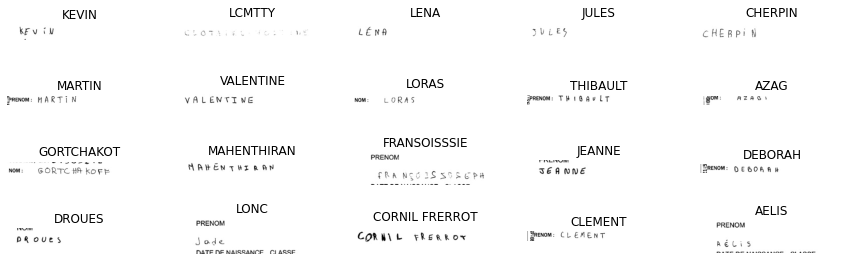

In [ ]:
test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    img=image
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    image = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    image = image/255.
    pred = reloaded_model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)